# Tuning one parameter at a time
### Using baseline data and baseline model
- Epochs (baseline: 30)
 - 50
 - 75
 - 100
- Early Stopping (baseline: none)
 - Patience 5
 - Patience 10
 - Patience 15

### Using baseline data and unique model
- Filters (baseline: 32 and 64)
 - Double (64 and 128)
 - Quad (128, and 256)
- Layers (3x3 input, 4x4 hidden, 3x3 hidden)
 - Increase each existing CNN dimension +1
 - Additional 5x5 layer
 - Additional 6x6 layer, then 5x5 layer
- Dropout (baseline: no dropout)
 - Dropout before flatten layer
 - Dropout before activation layer

### Using unique data and baseline model
- Image Transforms (baseline: none)
 - Shift
 - Shear
 - Zoom
 - Zoom, applied to Validation and Test
 - Shift, Shear, and Zoom
- Image Size (baseline: 64x64)
 - 128x128
 - 256x256


In [4]:
pip install Pillow --user

     |████████████████████████████████| 2.1MB 1.7MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import time
import matplotlib.pyplot as plt
import scipy
import numpy as np
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models, layers
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn import metrics
import itertools

%matplotlib inline

np.random.seed(123)

Using TensorFlow backend.


In [4]:
# memory management
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.9)

AttributeError: module 'tensorflow' has no attribute 'GPUOptions'

In [8]:
pip install sklearn --user

     |████████████████████████████████| 7.1MB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 296kB 627kB/s eta 0:00:01
Failed to build sklearn
    Running setup.py install for sklearn ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install Keras --user

     |████████████████████████████████| 378kB 1.1MB/s eta 0:00:01
     |████████████████████████████████| 276kB 1.3MB/s eta 0:00:01
Failed to build pyyaml
    Running setup.py install for pyyaml ... done
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
train_folder = os.path.join('train')
train_pneum = os.path.join(train_folder, 'PNEUMONIA')
train_norm = os.path.join(train_folder, 'NORMAL')

test_folder = os.path.join('test')
test_pneum = os.path.join(test_folder, 'PNEUMONIA')
test_norm = os.path.join(test_folder, 'NORMAL')

val_folder = os.path.join('val')
val_pneum = os.path.join(val_folder, 'PNEUMONIA')
val_norm = os.path.join(val_folder, 'NORMAL')

In [3]:
print('There are', len(os.listdir(train_pneum)), 'pneumonia images in the train set')
print('There are', len(os.listdir(train_norm)), 'normal images in the train set')
print('There are', len(os.listdir(test_pneum)), 'pneumonia images in the test set')
print('There are', len(os.listdir(test_norm)), 'normal images in the test set')
print('There are', len(os.listdir(val_pneum)), 'pneumonia images in the val set')
print('There are', len(os.listdir(val_norm)), 'normal images in the val set')

There are 3876 pneumonia images in the train set
There are 1342 normal images in the train set
There are 390 pneumonia images in the test set
There are 234 normal images in the test set
There are 9 pneumonia images in the val set
There are 9 normal images in the val set


# Baseline

## Baseline Data

In [4]:
train_generator_base = ImageDataGenerator(rescale=1./255).flow_from_directory(train_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 5218)
test_generator_base = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 624)
val_generator_base = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 18)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [5]:
class_labels_base = list(train_generator_base.class_indices.keys())
train_images_base, train_labels_base = next(train_generator_base)
test_images_base, test_labels_base = next(test_generator_base)
val_images_base, val_labels_base = next(val_generator_base)
train_y_base = np.reshape(train_labels_base[:,0], (5216,1))
test_y_base = np.reshape(test_labels_base[:,0], (624,1))
val_y_base = np.reshape(val_labels_base[:,0], (16,1))
print ("train_images shape: " + str(train_images_base.shape))
print ("train_labels shape: " + str(train_labels_base.shape))
print ("test_images shape: " + str(test_images_base.shape))
print ("test_labels shape: " + str(test_labels_base.shape))
print ("val_images shape: " + str(val_images_base.shape))
print ("val_labels shape: " + str(val_labels_base.shape))

train_images shape: (5216, 64, 64, 1)
train_labels shape: (5216, 2)
test_images shape: (624, 64, 64, 1)
test_labels shape: (624, 2)
val_images shape: (16, 64, 64, 1)
val_labels shape: (16, 2)


## Baseline Model

In [6]:
model_base = models.Sequential()
model_base.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_base.add(layers.MaxPooling2D((2, 2)))

model_base.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_base.add(layers.MaxPooling2D((2, 2)))

model_base.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_base.add(layers.MaxPooling2D((2, 2)))

model_base.add(layers.Flatten())
model_base.add(layers.Dense(64, activation='relu'))
model_base.add(layers.Dense(1, activation='sigmoid'))

model_base.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

## Training Baseline Model with Baseline Data

In [7]:
%%time
history_base = model_base.fit(train_images_base,
                    train_y_base,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 2s 447us/step - loss: 0.5983 - acc: 0.7379 - val_loss: 0.8094 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 1s 203us/step - loss: 0.5695 - acc: 0.7429 - val_loss: 0.8624 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 1s 205us/step - loss: 0.5621 - acc: 0.7429 - val_loss: 0.8462 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 1s 215us/step - loss: 0.5502 - acc: 0.7429 - val_loss: 0.7599 - val_acc: 0.5000
Epoch 5/30
5216/5216 [==============================] - 1s 204us/step - loss: 0.5215 - acc: 0.7429 - val_loss: 0.6663 - val_acc: 0.5625
Epoch 6/30
5216/5216 [==============================] - 1s 206us/step - loss: 0.4654 - acc: 0.7726 - val_loss: 1.2964 - val_acc: 0.5000
Epoch 7/30
5216/5216 [==============================] - 1s 212us/step - loss: 0.4376 - acc: 0.8062 - val_loss: 0.7532 - val_acc: 0.5625
Ep

Accuracy 
 Train: 0.976, Test: 0.724
Loss 
 Train: 0.066, Test: 1.224 



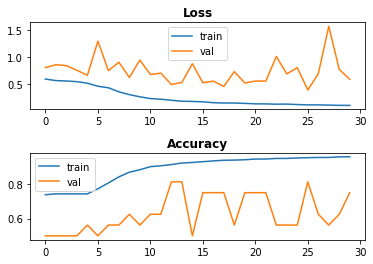



Confusion Matrix, without normalization


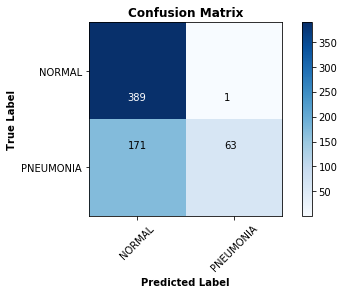



              precision    recall  f1-score   support

      NORMAL       0.69      1.00      0.82       390
   PNEUMONIA       0.98      0.27      0.42       234

    accuracy                           0.72       624
   macro avg       0.84      0.63      0.62       624
weighted avg       0.80      0.72      0.67       624



In [22]:
print(evaluate_test(model_base, history_base, class_labels_base, train_images_base, test_images_base, train_y_base, test_y_base))

# Tuning parameters using baseline data and baseline model

## Epoch (Baseline: 30)

### 50 epochs

In [18]:
model_epoch_50 = models.Sequential()
model_epoch_50.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_epoch_50.add(layers.MaxPooling2D((2, 2)))

model_epoch_50.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_epoch_50.add(layers.MaxPooling2D((2, 2)))

model_epoch_50.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_epoch_50.add(layers.MaxPooling2D((2, 2)))

model_epoch_50.add(layers.Flatten())
model_epoch_50.add(layers.Dense(64, activation='relu'))
model_epoch_50.add(layers.Dense(1, activation='sigmoid'))

model_epoch_50.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [19]:
%%time
history_epoch_50 = model_epoch_50.fit(train_images_base,
                    train_y_base,
                    epochs=50,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 5216 samples, validate on 16 samples
Epoch 1/50
5216/5216 [==============================] - 1s 232us/step - loss: 0.5958 - acc: 0.7375 - val_loss: 0.7909 - val_acc: 0.5000
Epoch 2/50
5216/5216 [==============================] - 1s 198us/step - loss: 0.5647 - acc: 0.7429 - val_loss: 0.7863 - val_acc: 0.5000
Epoch 3/50
5216/5216 [==============================] - 1s 197us/step - loss: 0.5516 - acc: 0.7429 - val_loss: 0.7820 - val_acc: 0.5000
Epoch 4/50
5216/5216 [==============================] - 1s 202us/step - loss: 0.5202 - acc: 0.7429 - val_loss: 0.7133 - val_acc: 0.5000
Epoch 5/50
5216/5216 [==============================] - 1s 205us/step - loss: 0.4571 - acc: 0.7805 - val_loss: 1.0652 - val_acc: 0.5000
Epoch 6/50
5216/5216 [==============================] - 1s 201us/step - loss: 0.4036 - acc: 0.8186 - val_loss: 0.6086 - val_acc: 0.6250
Epoch 7/50
5216/5216 [==============================] - 1s 214us/step - loss: 0.3378 - acc: 0.8566 - val_loss: 0.7702 - val_acc: 0.6250
Ep

Accuracy 
 Train: 0.963, Test: 0.705
Loss 
 Train: 0.095, Test: 1.284 



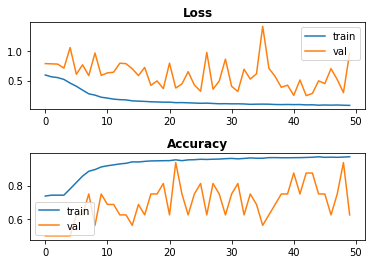



Confusion Matrix, without normalization


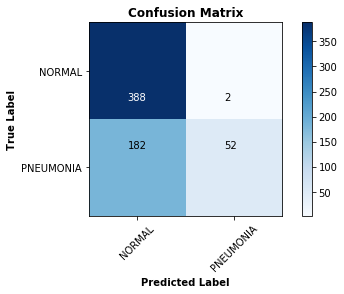



              precision    recall  f1-score   support

      NORMAL       0.68      0.99      0.81       390
   PNEUMONIA       0.96      0.22      0.36       234

    accuracy                           0.71       624
   macro avg       0.82      0.61      0.58       624
weighted avg       0.79      0.71      0.64       624



In [23]:
print(evaluate_test(model_epoch_50, history_epoch_50, class_labels_base, train_images_base, test_images_base, train_y_base, test_y_base))

### 75 epochs

In [24]:
model_epoch_75 = models.Sequential()
model_epoch_75.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_epoch_75.add(layers.MaxPooling2D((2, 2)))

model_epoch_75.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_epoch_75.add(layers.MaxPooling2D((2, 2)))

model_epoch_75.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_epoch_75.add(layers.MaxPooling2D((2, 2)))

model_epoch_75.add(layers.Flatten())
model_epoch_75.add(layers.Dense(64, activation='relu'))
model_epoch_75.add(layers.Dense(1, activation='sigmoid'))

model_epoch_75.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [25]:
%%time
history_epoch_75 = model_epoch_75.fit(train_images_base,
                    train_y_base,
                    epochs=75,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 5216 samples, validate on 16 samples
Epoch 1/75
5216/5216 [==============================] - 1s 215us/step - loss: 0.6048 - acc: 0.7431 - val_loss: 0.8201 - val_acc: 0.5000
Epoch 2/75
5216/5216 [==============================] - 1s 196us/step - loss: 0.5708 - acc: 0.7429 - val_loss: 0.8435 - val_acc: 0.5000
Epoch 3/75
5216/5216 [==============================] - 1s 198us/step - loss: 0.5664 - acc: 0.7429 - val_loss: 0.8374 - val_acc: 0.5000
Epoch 4/75
5216/5216 [==============================] - 1s 195us/step - loss: 0.5605 - acc: 0.7429 - val_loss: 0.7884 - val_acc: 0.5000
Epoch 5/75
5216/5216 [==============================] - 1s 192us/step - loss: 0.5509 - acc: 0.7429 - val_loss: 0.7971 - val_acc: 0.5000
Epoch 6/75
5216/5216 [==============================] - 1s 197us/step - loss: 0.5285 - acc: 0.7429 - val_loss: 0.7885 - val_acc: 0.5000
Epoch 7/75
5216/5216 [==============================] - 1s 195us/step - loss: 0.4809 - acc: 0.7561 - val_loss: 0.7696 - val_acc: 0.5000
Ep

5216/5216 [==============================] - 1s 196us/step - loss: 0.0741 - acc: 0.9741 - val_loss: 0.5989 - val_acc: 0.7500
Epoch 61/75
5216/5216 [==============================] - 1s 196us/step - loss: 0.0721 - acc: 0.9730 - val_loss: 0.4969 - val_acc: 0.7500
Epoch 62/75
5216/5216 [==============================] - 1s 196us/step - loss: 0.0740 - acc: 0.9730 - val_loss: 0.8244 - val_acc: 0.6250
Epoch 63/75
5216/5216 [==============================] - 1s 193us/step - loss: 0.0709 - acc: 0.9720 - val_loss: 0.7498 - val_acc: 0.6250
Epoch 64/75
5216/5216 [==============================] - 1s 195us/step - loss: 0.0696 - acc: 0.9758 - val_loss: 0.3120 - val_acc: 0.8125
Epoch 65/75
5216/5216 [==============================] - 1s 197us/step - loss: 0.0691 - acc: 0.9745 - val_loss: 0.2747 - val_acc: 0.8125
Epoch 66/75
5216/5216 [==============================] - 1s 196us/step - loss: 0.0675 - acc: 0.9758 - val_loss: 0.2253 - val_acc: 0.8750
Epoch 67/75
5216/5216 [==============================

Accuracy 
 Train: 0.981, Test: 0.737
Loss 
 Train: 0.054, Test: 1.007 



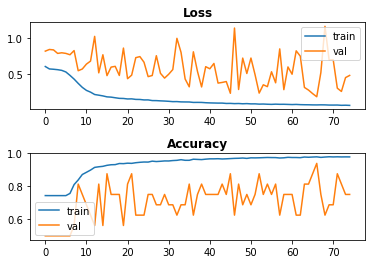



Confusion Matrix, without normalization


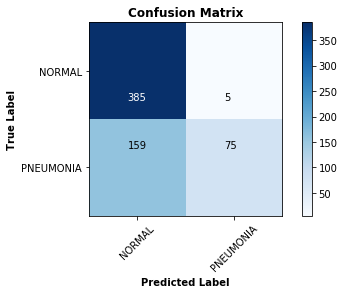



              precision    recall  f1-score   support

      NORMAL       0.71      0.99      0.82       390
   PNEUMONIA       0.94      0.32      0.48       234

    accuracy                           0.74       624
   macro avg       0.82      0.65      0.65       624
weighted avg       0.79      0.74      0.69       624



In [26]:
print(evaluate_test(model_epoch_75, history_epoch_75, class_labels_base, train_images_base, test_images_base, train_y_base, test_y_base))

### 100 epochs

In [27]:
model_epoch_100 = models.Sequential()
model_epoch_100.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_epoch_100.add(layers.MaxPooling2D((2, 2)))

model_epoch_100.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_epoch_100.add(layers.MaxPooling2D((2, 2)))

model_epoch_100.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_epoch_100.add(layers.MaxPooling2D((2, 2)))

model_epoch_100.add(layers.Flatten())
model_epoch_100.add(layers.Dense(64, activation='relu'))
model_epoch_100.add(layers.Dense(1, activation='sigmoid'))

model_epoch_100.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [28]:
%%time
history_epoch_100 = model_epoch_100.fit(train_images_base,
                    train_y_base,
                    epochs=100,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 5216 samples, validate on 16 samples
Epoch 1/100
5216/5216 [==============================] - 1s 222us/step - loss: 0.5806 - acc: 0.7429 - val_loss: 0.8036 - val_acc: 0.5000
Epoch 2/100
5216/5216 [==============================] - 1s 200us/step - loss: 0.5617 - acc: 0.7429 - val_loss: 0.8104 - val_acc: 0.5000
Epoch 3/100
5216/5216 [==============================] - 1s 197us/step - loss: 0.5413 - acc: 0.7429 - val_loss: 0.7588 - val_acc: 0.5000
Epoch 4/100
5216/5216 [==============================] - 1s 199us/step - loss: 0.4919 - acc: 0.7556 - val_loss: 0.6874 - val_acc: 0.5625
Epoch 5/100
5216/5216 [==============================] - 1s 200us/step - loss: 0.4389 - acc: 0.8090 - val_loss: 0.7958 - val_acc: 0.5625
Epoch 6/100
5216/5216 [==============================] - 1s 198us/step - loss: 0.4018 - acc: 0.8259 - val_loss: 0.6080 - val_acc: 0.5625
Epoch 7/100
5216/5216 [==============================] - 1s 209us/step - loss: 0.3412 - acc: 0.8545 - val_loss: 0.5285 - val_acc: 0.

5216/5216 [==============================] - 1s 188us/step - loss: 0.0644 - acc: 0.9749 - val_loss: 0.1760 - val_acc: 0.9375
Epoch 61/100
5216/5216 [==============================] - 1s 194us/step - loss: 0.0670 - acc: 0.9735 - val_loss: 0.6641 - val_acc: 0.6875
Epoch 62/100
5216/5216 [==============================] - 1s 196us/step - loss: 0.0601 - acc: 0.9783 - val_loss: 0.2417 - val_acc: 0.8750
Epoch 63/100
5216/5216 [==============================] - 1s 191us/step - loss: 0.0611 - acc: 0.9760 - val_loss: 0.5496 - val_acc: 0.6875
Epoch 64/100
5216/5216 [==============================] - 1s 197us/step - loss: 0.0596 - acc: 0.9774 - val_loss: 0.5769 - val_acc: 0.6875
Epoch 65/100
5216/5216 [==============================] - 1s 194us/step - loss: 0.0610 - acc: 0.9787 - val_loss: 0.9758 - val_acc: 0.5625
Epoch 66/100
5216/5216 [==============================] - 1s 194us/step - loss: 0.0595 - acc: 0.9774 - val_loss: 0.4793 - val_acc: 0.6875
Epoch 67/100
5216/5216 [=======================

Accuracy 
 Train: 0.992, Test: 0.750
Loss 
 Train: 0.029, Test: 1.193 



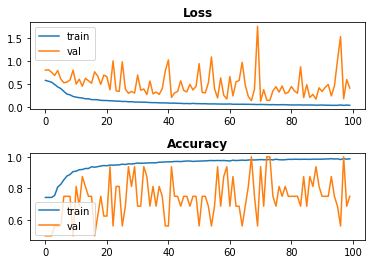



Confusion Matrix, without normalization


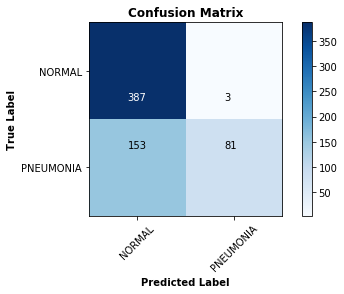



              precision    recall  f1-score   support

      NORMAL       0.72      0.99      0.83       390
   PNEUMONIA       0.96      0.35      0.51       234

    accuracy                           0.75       624
   macro avg       0.84      0.67      0.67       624
weighted avg       0.81      0.75      0.71       624



In [29]:
print(evaluate_test(model_epoch_100, history_epoch_100, class_labels_base, train_images_base, test_images_base, train_y_base, test_y_base))

## Early Stopping

### Patience 5

In [30]:
model_early_5 = models.Sequential()
model_early_5.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_early_5.add(layers.MaxPooling2D((2, 2)))

model_early_5.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_early_5.add(layers.MaxPooling2D((2, 2)))

model_early_5.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_early_5.add(layers.MaxPooling2D((2, 2)))

model_early_5.add(layers.Flatten())
model_early_5.add(layers.Dense(64, activation='relu'))
model_early_5.add(layers.Dense(1, activation='sigmoid'))

model_early_5.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [31]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 5)]
history_early_5 = model_early_5.fit(train_images_base,
                    train_y_base,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base),
                    callbacks=early_stopping)

Train on 5216 samples, validate on 16 samples
Epoch 1/100
5216/5216 [==============================] - 1s 243us/step - loss: 0.5789 - acc: 0.7429 - val_loss: 0.8234 - val_acc: 0.5000
Epoch 2/100
5216/5216 [==============================] - 1s 212us/step - loss: 0.5524 - acc: 0.7429 - val_loss: 0.7700 - val_acc: 0.5000
Epoch 3/100
5216/5216 [==============================] - 1s 204us/step - loss: 0.5097 - acc: 0.7444 - val_loss: 0.7324 - val_acc: 0.5625
Epoch 4/100
5216/5216 [==============================] - 1s 217us/step - loss: 0.4461 - acc: 0.8008 - val_loss: 0.9870 - val_acc: 0.5625
Epoch 5/100
5216/5216 [==============================] - 1s 210us/step - loss: 0.3775 - acc: 0.8353 - val_loss: 0.5958 - val_acc: 0.7500
Epoch 6/100
5216/5216 [==============================] - 1s 215us/step - loss: 0.3205 - acc: 0.8656 - val_loss: 1.5134 - val_acc: 0.5625
Epoch 7/100
5216/5216 [==============================] - 1s 214us/step - loss: 0.2672 - acc: 0.8871 - val_loss: 1.4196 - val_acc: 0.

Accuracy 
 Train: 0.870, Test: 0.673
Loss 
 Train: 0.289, Test: 0.927 



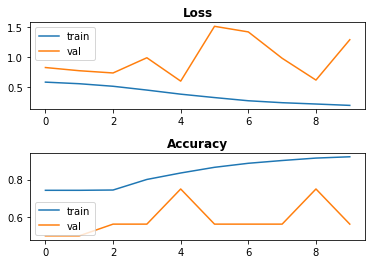



Confusion Matrix, without normalization


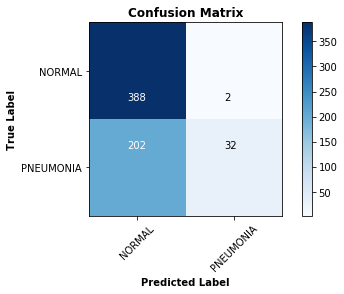



              precision    recall  f1-score   support

      NORMAL       0.66      0.99      0.79       390
   PNEUMONIA       0.94      0.14      0.24       234

    accuracy                           0.67       624
   macro avg       0.80      0.57      0.52       624
weighted avg       0.76      0.67      0.58       624



In [32]:
print(evaluate_test(model_early_5, history_early_5, class_labels_base, train_images_base, test_images_base, train_y_base, test_y_base))

### Patience 10

In [33]:
model_early_10 = models.Sequential()
model_early_10.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_early_10.add(layers.MaxPooling2D((2, 2)))

model_early_10.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_early_10.add(layers.MaxPooling2D((2, 2)))

model_early_10.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_early_10.add(layers.MaxPooling2D((2, 2)))

model_early_10.add(layers.Flatten())
model_early_10.add(layers.Dense(64, activation='relu'))
model_early_10.add(layers.Dense(1, activation='sigmoid'))

model_early_10.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [34]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 10)]
history_early_10 = model_early_10.fit(train_images_base,
                    train_y_base,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base),
                    callbacks=early_stopping)

Train on 5216 samples, validate on 16 samples
Epoch 1/200
5216/5216 [==============================] - 1s 241us/step - loss: 0.5843 - acc: 0.7419 - val_loss: 0.8053 - val_acc: 0.5000
Epoch 2/200
5216/5216 [==============================] - 1s 204us/step - loss: 0.5610 - acc: 0.7429 - val_loss: 0.8310 - val_acc: 0.5000
Epoch 3/200
5216/5216 [==============================] - 1s 205us/step - loss: 0.5387 - acc: 0.7429 - val_loss: 0.7076 - val_acc: 0.5000
Epoch 4/200
5216/5216 [==============================] - 1s 216us/step - loss: 0.4846 - acc: 0.7605 - val_loss: 0.6378 - val_acc: 0.6250
Epoch 5/200
5216/5216 [==============================] - 1s 209us/step - loss: 0.4304 - acc: 0.8058 - val_loss: 0.5632 - val_acc: 0.8125
Epoch 6/200
5216/5216 [==============================] - 1s 212us/step - loss: 0.3750 - acc: 0.8374 - val_loss: 0.6847 - val_acc: 0.6250
Epoch 7/200
5216/5216 [==============================] - 1s 205us/step - loss: 0.3062 - acc: 0.8706 - val_loss: 0.6076 - val_acc: 0.

Accuracy 
 Train: 0.962, Test: 0.734
Loss 
 Train: 0.100, Test: 0.903 



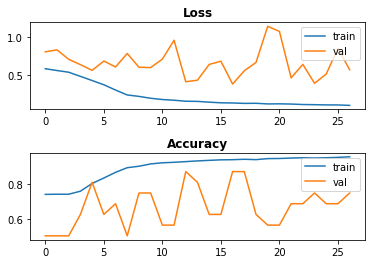



Confusion Matrix, without normalization


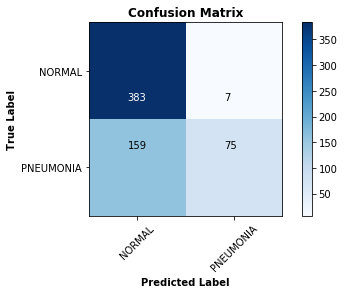



              precision    recall  f1-score   support

      NORMAL       0.71      0.98      0.82       390
   PNEUMONIA       0.91      0.32      0.47       234

    accuracy                           0.73       624
   macro avg       0.81      0.65      0.65       624
weighted avg       0.78      0.73      0.69       624



In [35]:
print(evaluate_test(model_early_10, history_early_10, class_labels_base, train_images_base, test_images_base, train_y_base, test_y_base))

### Patience 15

In [36]:
model_early_15 = models.Sequential()
model_early_15.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_early_15.add(layers.MaxPooling2D((2, 2)))

model_early_15.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_early_15.add(layers.MaxPooling2D((2, 2)))

model_early_15.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_early_15.add(layers.MaxPooling2D((2, 2)))

model_early_15.add(layers.Flatten())
model_early_15.add(layers.Dense(64, activation='relu'))
model_early_15.add(layers.Dense(1, activation='sigmoid'))

model_early_15.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [37]:
%%time
early_stopping = [EarlyStopping(monitor='val_loss', patience = 15)]
history_early_15 = model_early_15.fit(train_images_base,
                    train_y_base,
                    epochs=200,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base),
                    callbacks=early_stopping)

Train on 5216 samples, validate on 16 samples
Epoch 1/200
5216/5216 [==============================] - 1s 241us/step - loss: 0.6022 - acc: 0.7360 - val_loss: 0.8092 - val_acc: 0.5000
Epoch 2/200
5216/5216 [==============================] - 1s 224us/step - loss: 0.5701 - acc: 0.7429 - val_loss: 0.8174 - val_acc: 0.5000
Epoch 3/200
5216/5216 [==============================] - 1s 212us/step - loss: 0.5653 - acc: 0.7429 - val_loss: 0.7795 - val_acc: 0.5000
Epoch 4/200
5216/5216 [==============================] - 1s 219us/step - loss: 0.5589 - acc: 0.7429 - val_loss: 0.8340 - val_acc: 0.5000
Epoch 5/200
5216/5216 [==============================] - 1s 220us/step - loss: 0.5451 - acc: 0.7429 - val_loss: 0.8553 - val_acc: 0.5000
Epoch 6/200
5216/5216 [==============================] - 1s 207us/step - loss: 0.5132 - acc: 0.7429 - val_loss: 0.7179 - val_acc: 0.5000
Epoch 7/200
5216/5216 [==============================] - 1s 211us/step - loss: 0.4560 - acc: 0.7799 - val_loss: 0.7366 - val_acc: 0.

5216/5216 [==============================] - 1s 205us/step - loss: 0.0726 - acc: 0.9720 - val_loss: 0.4625 - val_acc: 0.7500
Epoch 61/200
5216/5216 [==============================] - 1s 209us/step - loss: 0.0770 - acc: 0.9703 - val_loss: 0.2326 - val_acc: 0.8750
Epoch 62/200
5216/5216 [==============================] - 1s 208us/step - loss: 0.0695 - acc: 0.9751 - val_loss: 0.3302 - val_acc: 0.8125
Epoch 63/200
5216/5216 [==============================] - 1s 205us/step - loss: 0.0695 - acc: 0.9745 - val_loss: 0.4576 - val_acc: 0.7500
Epoch 64/200
5216/5216 [==============================] - 1s 205us/step - loss: 0.0695 - acc: 0.9747 - val_loss: 0.3919 - val_acc: 0.7500
Epoch 65/200
5216/5216 [==============================] - 1s 207us/step - loss: 0.0676 - acc: 0.9766 - val_loss: 0.3886 - val_acc: 0.7500
Epoch 66/200
5216/5216 [==============================] - 1s 214us/step - loss: 0.0646 - acc: 0.9766 - val_loss: 0.1654 - val_acc: 0.8750
Epoch 67/200
5216/5216 [=======================

Accuracy 
 Train: 0.986, Test: 0.728
Loss 
 Train: 0.041, Test: 1.273 



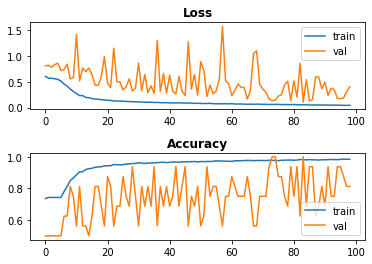



Confusion Matrix, without normalization


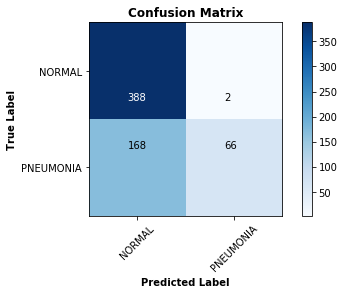



              precision    recall  f1-score   support

      NORMAL       0.70      0.99      0.82       390
   PNEUMONIA       0.97      0.28      0.44       234

    accuracy                           0.73       624
   macro avg       0.83      0.64      0.63       624
weighted avg       0.80      0.73      0.68       624



In [38]:
print(evaluate_test(model_early_15, history_early_15, class_labels_base, train_images_base, test_images_base, train_y_base, test_y_base))

# Tuning parameters using baseline data and unique model

## Filter count (baseline: 32 and 64)

### Double (64 and 128)

In [41]:
model_filter_doub = models.Sequential()
model_filter_doub.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_filter_doub.add(layers.MaxPooling2D((2, 2)))

model_filter_doub.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_filter_doub.add(layers.MaxPooling2D((2, 2)))

model_filter_doub.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_filter_doub.add(layers.MaxPooling2D((2, 2)))

model_filter_doub.add(layers.Flatten())
model_filter_doub.add(layers.Dense(128, activation='relu'))
model_filter_doub.add(layers.Dense(1, activation='sigmoid'))

model_filter_doub.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [42]:
%%time
history_filter_doub = model_filter_doub.fit(train_images_base,
                    train_y_base,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 2s 433us/step - loss: 0.5856 - acc: 0.7429 - val_loss: 0.8169 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 2s 354us/step - loss: 0.5656 - acc: 0.7429 - val_loss: 0.9048 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 2s 358us/step - loss: 0.5556 - acc: 0.7429 - val_loss: 0.7853 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 2s 350us/step - loss: 0.5314 - acc: 0.7429 - val_loss: 0.8812 - val_acc: 0.5000
Epoch 5/30
5216/5216 [==============================] - 2s 353us/step - loss: 0.4761 - acc: 0.7604 - val_loss: 1.2280 - val_acc: 0.5000
Epoch 6/30
5216/5216 [==============================] - 2s 356us/step - loss: 0.4385 - acc: 0.8004 - val_loss: 0.8500 - val_acc: 0.5625
Epoch 7/30
5216/5216 [==============================] - 2s 356us/step - loss: 0.3605 - acc: 0.8449 - val_loss: 0.6510 - val_acc: 0.6250
Ep

Accuracy 
 Train: 0.963, Test: 0.745
Loss 
 Train: 0.098, Test: 0.786 



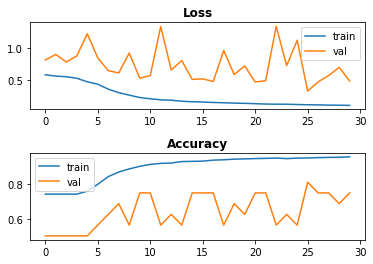



Confusion Matrix, without normalization


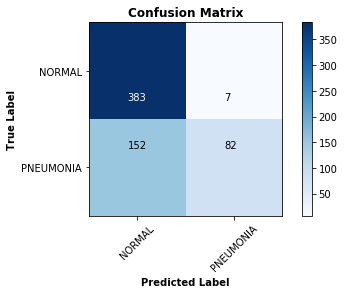



              precision    recall  f1-score   support

      NORMAL       0.72      0.98      0.83       390
   PNEUMONIA       0.92      0.35      0.51       234

    accuracy                           0.75       624
   macro avg       0.82      0.67      0.67       624
weighted avg       0.79      0.75      0.71       624



In [43]:
print(evaluate_test(model_filter_doub, history_filter_doub, class_labels_base, train_images_base, test_images_base, train_y_base, test_y_base))

### Quad (128 and 256)

In [44]:
model_filter_quad = models.Sequential()
model_filter_quad.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_filter_quad.add(layers.MaxPooling2D((2, 2)))

model_filter_quad.add(layers.Conv2D(128, (4, 4), activation='relu'))
model_filter_quad.add(layers.MaxPooling2D((2, 2)))

model_filter_quad.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_filter_quad.add(layers.MaxPooling2D((2, 2)))

model_filter_quad.add(layers.Flatten())
model_filter_quad.add(layers.Dense(256, activation='relu'))
model_filter_quad.add(layers.Dense(1, activation='sigmoid'))

model_filter_quad.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [45]:
%%time
history_filter_quad = model_filter_quad.fit(train_images_base,
                    train_y_base,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 4s 862us/step - loss: 0.5979 - acc: 0.7318 - val_loss: 0.8417 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 4s 757us/step - loss: 0.5673 - acc: 0.7429 - val_loss: 0.8200 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 4s 755us/step - loss: 0.5581 - acc: 0.7429 - val_loss: 0.8009 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 4s 787us/step - loss: 0.5409 - acc: 0.7429 - val_loss: 0.8537 - val_acc: 0.5000
Epoch 5/30
5216/5216 [==============================] - 4s 789us/step - loss: 0.4962 - acc: 0.7508 - val_loss: 1.1128 - val_acc: 0.5000
Epoch 6/30
5216/5216 [==============================] - 4s 755us/step - loss: 0.4562 - acc: 0.7857 - val_loss: 1.0162 - val_acc: 0.5625
Epoch 7/30
5216/5216 [==============================] - 4s 776us/step - loss: 0.3918 - acc: 0.8275 - val_loss: 0.5437 - val_acc: 0.8125
Ep

Accuracy 
 Train: 0.960, Test: 0.729
Loss 
 Train: 0.101, Test: 0.898 



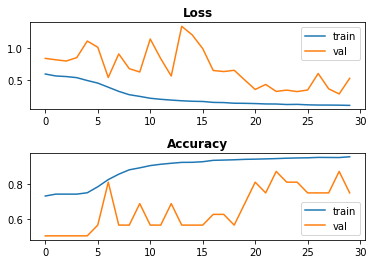



Confusion Matrix, without normalization


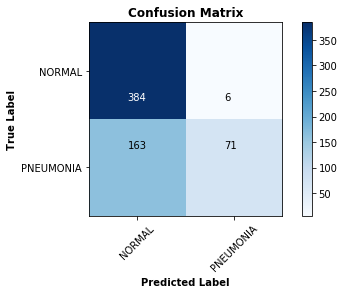



              precision    recall  f1-score   support

      NORMAL       0.70      0.98      0.82       390
   PNEUMONIA       0.92      0.30      0.46       234

    accuracy                           0.73       624
   macro avg       0.81      0.64      0.64       624
weighted avg       0.78      0.73      0.68       624



In [46]:
print(evaluate_test(model_filter_quad, history_filter_quad, class_labels_base, train_images_base, test_images_base, train_y_base, test_y_base))

### Oct (256 and 512)

In [47]:
model_filter_oct = models.Sequential()
model_filter_oct.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_filter_oct.add(layers.MaxPooling2D((2, 2)))

model_filter_oct.add(layers.Conv2D(256, (4, 4), activation='relu'))
model_filter_oct.add(layers.MaxPooling2D((2, 2)))

model_filter_oct.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_filter_oct.add(layers.MaxPooling2D((2, 2)))

model_filter_oct.add(layers.Flatten())
model_filter_oct.add(layers.Dense(512, activation='relu'))
model_filter_oct.add(layers.Dense(1, activation='sigmoid'))

model_filter_oct.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [48]:
%%time
history_filter_oct = model_filter_oct.fit(train_images_base,
                    train_y_base,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 11s 2ms/step - loss: 0.5864 - acc: 0.7429 - val_loss: 0.8241 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 11s 2ms/step - loss: 0.5633 - acc: 0.7429 - val_loss: 0.8322 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 10s 2ms/step - loss: 0.5492 - acc: 0.7429 - val_loss: 0.8530 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 11s 2ms/step - loss: 0.5130 - acc: 0.7446 - val_loss: 0.7687 - val_acc: 0.5000
Epoch 5/30
5216/5216 [==============================] - 10s 2ms/step - loss: 0.4622 - acc: 0.7780 - val_loss: 0.6068 - val_acc: 0.5625
Epoch 6/30
5216/5216 [==============================] - 10s 2ms/step - loss: 0.3995 - acc: 0.8280 - val_loss: 0.6833 - val_acc: 0.6250
Epoch 7/30
5216/5216 [==============================] - 10s 2ms/step - loss: 0.3350 - acc: 0.8597 - val_loss: 1.0359 - val_acc: 0.5625
Epoch 8/3

Accuracy 
 Train: 0.965, Test: 0.734
Loss 
 Train: 0.094, Test: 0.881 



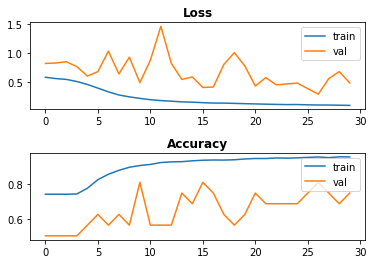



Confusion Matrix, without normalization


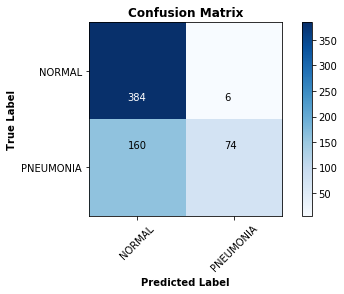



              precision    recall  f1-score   support

      NORMAL       0.71      0.98      0.82       390
   PNEUMONIA       0.93      0.32      0.47       234

    accuracy                           0.73       624
   macro avg       0.82      0.65      0.65       624
weighted avg       0.79      0.73      0.69       624



In [49]:
print(evaluate_test(model_filter_oct, history_filter_oct, class_labels_base, train_images_base, test_images_base, train_y_base, test_y_base))

## Layers (baseline 3x3 input, 4x4 hidden, 3x3 hidden)

### Each existing CNN dimension +1

In [52]:
model_layer_plus = models.Sequential()
model_layer_plus.add(layers.Conv2D(32, (4, 4), activation='relu', input_shape=(64, 64, 1)))
model_layer_plus.add(layers.MaxPooling2D((2, 2)))

model_layer_plus.add(layers.Conv2D(32, (5, 5), activation='relu'))
model_layer_plus.add(layers.MaxPooling2D((2, 2)))

model_layer_plus.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_layer_plus.add(layers.MaxPooling2D((2, 2)))

model_layer_plus.add(layers.Flatten())
model_layer_plus.add(layers.Dense(64, activation='relu'))
model_layer_plus.add(layers.Dense(1, activation='sigmoid'))

model_layer_plus.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [53]:
%%time
history_layer_plus = model_layer_plus.fit(train_images_base,
                    train_y_base,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 1s 235us/step - loss: 0.5849 - acc: 0.7429 - val_loss: 0.8508 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 1s 206us/step - loss: 0.5673 - acc: 0.7429 - val_loss: 0.8400 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 1s 206us/step - loss: 0.5600 - acc: 0.7429 - val_loss: 0.8011 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 1s 206us/step - loss: 0.5468 - acc: 0.7429 - val_loss: 0.8686 - val_acc: 0.5000
Epoch 5/30
5216/5216 [==============================] - 1s 204us/step - loss: 0.5167 - acc: 0.7431 - val_loss: 0.9474 - val_acc: 0.5000
Epoch 6/30
5216/5216 [==============================] - 1s 203us/step - loss: 0.4552 - acc: 0.7851 - val_loss: 0.8770 - val_acc: 0.5625
Epoch 7/30
5216/5216 [==============================] - 1s 206us/step - loss: 0.3707 - acc: 0.8428 - val_loss: 0.5095 - val_acc: 0.8125
Ep

Accuracy 
 Train: 0.943, Test: 0.686
Loss 
 Train: 0.143, Test: 1.193 



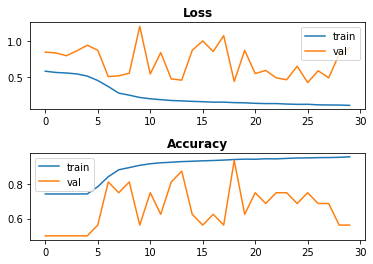



Confusion Matrix, without normalization


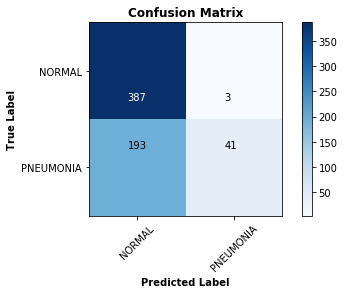



              precision    recall  f1-score   support

      NORMAL       0.67      0.99      0.80       390
   PNEUMONIA       0.93      0.18      0.29       234

    accuracy                           0.69       624
   macro avg       0.80      0.58      0.55       624
weighted avg       0.77      0.69      0.61       624



In [54]:
print(evaluate_test(model_layer_plus, history_layer_plus, class_labels_base, train_images_base, test_images_base, train_y_base, test_y_base))

### Additional 5x5 layer

In [55]:
model_layer_five = models.Sequential()
model_layer_five.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_layer_five.add(layers.MaxPooling2D((2, 2)))

model_layer_five.add(layers.Conv2D(32, (5, 5), activation='relu'))
model_layer_five.add(layers.MaxPooling2D((2, 2)))

model_layer_five.add(layers.Conv2D(64, (4, 4), activation='relu'))
model_layer_five.add(layers.MaxPooling2D((2, 2)))

model_layer_five.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_layer_five.add(layers.MaxPooling2D((2, 2)))

model_layer_five.add(layers.Flatten())
model_layer_five.add(layers.Dense(64, activation='relu'))
model_layer_five.add(layers.Dense(1, activation='sigmoid'))

model_layer_five.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [56]:
%%time
history_layer_five = model_layer_five.fit(train_images_base,
                    train_y_base,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 1s 270us/step - loss: 0.6216 - acc: 0.7429 - val_loss: 0.7994 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 1s 226us/step - loss: 0.5697 - acc: 0.7429 - val_loss: 0.8265 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 1s 225us/step - loss: 0.5680 - acc: 0.7429 - val_loss: 0.8374 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 1s 220us/step - loss: 0.5659 - acc: 0.7429 - val_loss: 0.8359 - val_acc: 0.5000
Epoch 5/30
5216/5216 [==============================] - 1s 227us/step - loss: 0.5633 - acc: 0.7429 - val_loss: 0.8750 - val_acc: 0.5000
Epoch 6/30
5216/5216 [==============================] - 1s 225us/step - loss: 0.5608 - acc: 0.7429 - val_loss: 0.8156 - val_acc: 0.5000
Epoch 7/30
5216/5216 [==============================] - 1s 220us/step - loss: 0.5552 - acc: 0.7429 - val_loss: 0.8258 - val_acc: 0.5000
Ep

Accuracy 
 Train: 0.935, Test: 0.788
Loss 
 Train: 0.166, Test: 0.503 



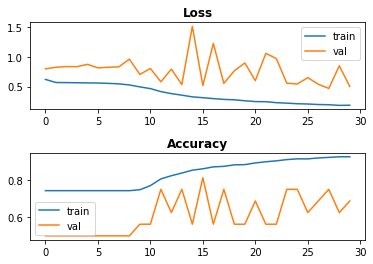



Confusion Matrix, without normalization


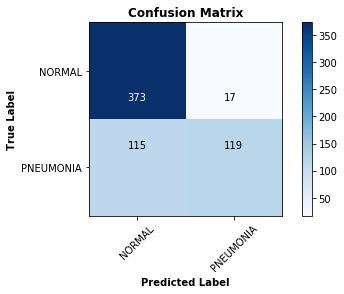



              precision    recall  f1-score   support

      NORMAL       0.76      0.96      0.85       390
   PNEUMONIA       0.88      0.51      0.64       234

    accuracy                           0.79       624
   macro avg       0.82      0.73      0.75       624
weighted avg       0.81      0.79      0.77       624



In [57]:
print(evaluate_test(model_layer_five, history_layer_five, class_labels_base, train_images_base, test_images_base, train_y_base, test_y_base))

### Additional 6x6 layer and 5x5 layer (doesn't work with input_shape size)

In [ ]:
model_layer_six = models.Sequential()
model_layer_six.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_layer_six.add(layers.MaxPooling2D((2, 2)))

model_layer_six.add(layers.Conv2D(32, (6, 6), activation='relu'))
model_layer_six.add(layers.MaxPooling2D((2, 2)))

model_layer_six.add(layers.Conv2D(64, (5, 5), activation='relu'))
model_layer_six.add(layers.MaxPooling2D((2, 2)))

model_layer_six.add(layers.Conv2D(128, (4, 4), activation='relu'))
model_layer_six.add(layers.MaxPooling2D((2, 2)))

model_layer_six.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_layer_six.add(layers.MaxPooling2D((2, 2)))

model_layer_six.add(layers.Flatten())
model_layer_six.add(layers.Dense(64, activation='relu'))
model_layer_six.add(layers.Dense(1, activation='sigmoid'))

model_layer_six.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

## Dropout (baseline: no dropout)

### Dropdown before Flatten

In [60]:
model_dropout_flatten = models.Sequential()
model_dropout_flatten.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_dropout_flatten.add(layers.MaxPooling2D((2, 2)))

model_dropout_flatten.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_dropout_flatten.add(layers.MaxPooling2D((2, 2)))

model_dropout_flatten.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_dropout_flatten.add(layers.MaxPooling2D((2, 2)))

model_dropout_flatten.add(Dropout(.3))
model_dropout_flatten.add(layers.Flatten())
model_dropout_flatten.add(layers.Dense(64, activation='relu'))
model_dropout_flatten.add(layers.Dense(1, activation='sigmoid'))

model_dropout_flatten.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [61]:
%%time
history_dropout_flatten = model_dropout_flatten.fit(train_images_base,
                    train_y_base,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 1s 231us/step - loss: 0.5979 - acc: 0.7425 - val_loss: 0.8666 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 1s 199us/step - loss: 0.5718 - acc: 0.7429 - val_loss: 0.8247 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 1s 209us/step - loss: 0.5623 - acc: 0.7429 - val_loss: 0.8181 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 1s 204us/step - loss: 0.5480 - acc: 0.7429 - val_loss: 0.7547 - val_acc: 0.5000
Epoch 5/30
5216/5216 [==============================] - 1s 202us/step - loss: 0.5242 - acc: 0.7458 - val_loss: 0.7421 - val_acc: 0.5000
Epoch 6/30
5216/5216 [==============================] - 1s 205us/step - loss: 0.4748 - acc: 0.7740 - val_loss: 1.0133 - val_acc: 0.5000
Epoch 7/30
5216/5216 [==============================] - 1s 203us/step - loss: 0.4384 - acc: 0.7981 - val_loss: 0.5658 - val_acc: 0.6875
Ep

Accuracy 
 Train: 0.932, Test: 0.816
Loss 
 Train: 0.174, Test: 0.456 



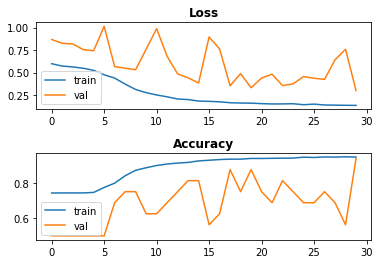



Confusion Matrix, without normalization


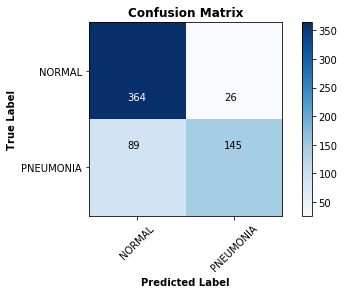



              precision    recall  f1-score   support

      NORMAL       0.80      0.93      0.86       390
   PNEUMONIA       0.85      0.62      0.72       234

    accuracy                           0.82       624
   macro avg       0.83      0.78      0.79       624
weighted avg       0.82      0.82      0.81       624



In [62]:
print(evaluate_test(model_dropout_flatten, history_dropout_flatten, class_labels_base, train_images_base, test_images_base, train_y_base, test_y_base))

### Dropout before Activation

In [66]:
model_dropout_activation = models.Sequential()
model_dropout_activation.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_dropout_activation.add(layers.MaxPooling2D((2, 2)))

model_dropout_activation.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_dropout_activation.add(layers.MaxPooling2D((2, 2)))

model_dropout_activation.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_dropout_activation.add(layers.MaxPooling2D((2, 2)))

model_dropout_activation.add(layers.Flatten())
model_dropout_activation.add(layers.Dense(64, activation='relu'))
model_dropout_activation.add(Dropout(.3))
model_dropout_activation.add(layers.Dense(1, activation='sigmoid'))

model_dropout_activation.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [67]:
%%time
history_dropout_activation = model_dropout_activation.fit(train_images_base,
                    train_y_base,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_base, val_y_base))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 1s 242us/step - loss: 0.5993 - acc: 0.7228 - val_loss: 0.7960 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 1s 201us/step - loss: 0.5761 - acc: 0.7429 - val_loss: 0.8071 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 1s 206us/step - loss: 0.5641 - acc: 0.7429 - val_loss: 0.7864 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 1s 199us/step - loss: 0.5530 - acc: 0.7429 - val_loss: 0.7263 - val_acc: 0.5000
Epoch 5/30
5216/5216 [==============================] - 1s 191us/step - loss: 0.5189 - acc: 0.7456 - val_loss: 0.9313 - val_acc: 0.5000
Epoch 6/30
5216/5216 [==============================] - 1s 188us/step - loss: 0.4742 - acc: 0.7768 - val_loss: 0.6834 - val_acc: 0.5625
Epoch 7/30
5216/5216 [==============================] - 1s 195us/step - loss: 0.4273 - acc: 0.8031 - val_loss: 2.0644 - val_acc: 0.5000
Ep

Accuracy 
 Train: 0.956, Test: 0.726
Loss 
 Train: 0.118, Test: 0.915 



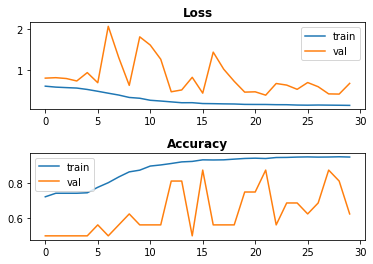



Confusion Matrix, without normalization


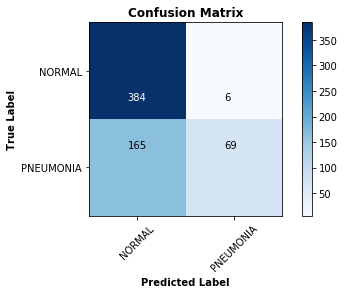



              precision    recall  f1-score   support

      NORMAL       0.70      0.98      0.82       390
   PNEUMONIA       0.92      0.29      0.45       234

    accuracy                           0.73       624
   macro avg       0.81      0.64      0.63       624
weighted avg       0.78      0.73      0.68       624



In [68]:
print(evaluate_test(model_dropout_activation, history_dropout_activation, class_labels_base, train_images_base, test_images_base, train_y_base, test_y_base))

# Tuning Parameters using unique data and baseline model

## Image Transforms (baseline: none)

### Width/Height Shift

In [84]:
train_generator_shift = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1).flow_from_directory(train_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 5218)
test_generator_shift = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 624)
val_generator_shift = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 18)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [85]:
class_labels_shift = list(train_generator_shift.class_indices.keys())
train_images_shift, train_labels_shift = next(train_generator_shift)
test_images_shift, test_labels_shift = next(test_generator_shift)
val_images_shift, val_labels_shift = next(val_generator_shift)
train_y_shift = np.reshape(train_labels_shift[:,0], (5216,1))
test_y_shift = np.reshape(test_labels_shift[:,0], (624,1))
val_y_shift = np.reshape(val_labels_shift[:,0], (16,1))
print ("train_images shape: " + str(train_images_shift.shape))
print ("train_labels shape: " + str(train_labels_shift.shape))
print ("test_images shape: " + str(test_images_shift.shape))
print ("test_labels shape: " + str(test_labels_shift.shape))
print ("val_images shape: " + str(val_images_shift.shape))
print ("val_labels shape: " + str(val_labels_shift.shape))

train_images shape: (5216, 64, 64, 1)
train_labels shape: (5216, 2)
test_images shape: (624, 64, 64, 1)
test_labels shape: (624, 2)
val_images shape: (16, 64, 64, 1)
val_labels shape: (16, 2)


In [86]:
model_transform_shift = models.Sequential()
model_transform_shift.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_transform_shift.add(layers.MaxPooling2D((2, 2)))

model_transform_shift.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_transform_shift.add(layers.MaxPooling2D((2, 2)))

model_transform_shift.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_transform_shift.add(layers.MaxPooling2D((2, 2)))

model_transform_shift.add(layers.Flatten())
model_transform_shift.add(layers.Dense(64, activation='relu'))
model_transform_shift.add(layers.Dense(1, activation='sigmoid'))

model_transform_shift.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [87]:
%%time
history_transform_shift = model_transform_shift.fit(train_images_shift,
                    train_y_shift,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_shift, val_y_shift))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 1s 241us/step - loss: 0.5938 - acc: 0.7412 - val_loss: 0.8460 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 1s 213us/step - loss: 0.5708 - acc: 0.7429 - val_loss: 0.7711 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 1s 219us/step - loss: 0.5663 - acc: 0.7429 - val_loss: 0.8455 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 1s 217us/step - loss: 0.5596 - acc: 0.7429 - val_loss: 0.8062 - val_acc: 0.5000
Epoch 5/30
5216/5216 [==============================] - 1s 222us/step - loss: 0.5478 - acc: 0.7429 - val_loss: 0.7851 - val_acc: 0.5000
Epoch 6/30
5216/5216 [==============================] - 1s 218us/step - loss: 0.5230 - acc: 0.7439 - val_loss: 0.6400 - val_acc: 0.6250
Epoch 7/30
5216/5216 [==============================] - 1s 223us/step - loss: 0.4879 - acc: 0.7701 - val_loss: 0.7316 - val_acc: 0.5625
Ep

Accuracy 
 Train: 0.919, Test: 0.723
Loss 
 Train: 0.197, Test: 0.873 



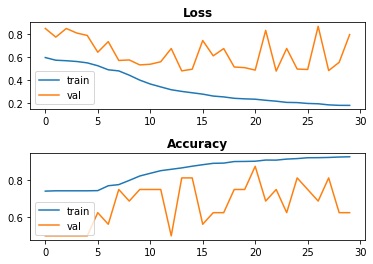



Confusion Matrix, without normalization


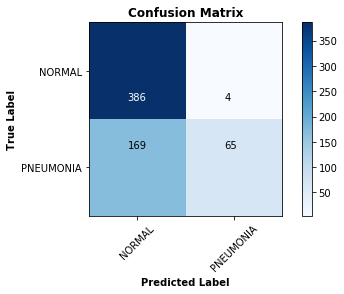



              precision    recall  f1-score   support

      NORMAL       0.70      0.99      0.82       390
   PNEUMONIA       0.94      0.28      0.43       234

    accuracy                           0.72       624
   macro avg       0.82      0.63      0.62       624
weighted avg       0.79      0.72      0.67       624



In [88]:
print(evaluate_test(model_transform_shift, history_transform_shift, class_labels_base, train_images_shift, test_images_shift, train_y_shift, test_y_shift))

### Shear Range 15 degeres

In [89]:
train_generator_shear = ImageDataGenerator(rescale=1./255,
                                           shear_range=15).flow_from_directory(train_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 5218)
test_generator_shear = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 624)
val_generator_shear = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 18)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [98]:
class_labels_shear = list(train_generator_shear.class_indices.keys())
train_images_shear, train_labels_shear = next(train_generator_shear)
test_images_shear, test_labels_shear = next(test_generator_shear)
val_images_shear, val_labels_shear = next(val_generator_shear)
train_y_shear = np.reshape(train_labels_shear[:,0], (5216,1))
test_y_shear = np.reshape(test_labels_shear[:,0], (624,1))
val_y_shear = np.reshape(val_labels_shear[:,0], (16,1))
print ("train_images shape: " + str(train_images_shear.shape))
print ("train_labels shape: " + str(train_labels_shear.shape))
print ("test_images shape: " + str(test_images_shear.shape))
print ("test_labels shape: " + str(test_labels_shear.shape))
print ("val_images shape: " + str(val_images_shear.shape))
print ("val_labels shape: " + str(val_labels_shear.shape))

train_images shape: (5216, 64, 64, 1)
train_labels shape: (5216, 2)
test_images shape: (624, 64, 64, 1)
test_labels shape: (624, 2)
val_images shape: (16, 64, 64, 1)
val_labels shape: (16, 2)


In [99]:
model_transform_shear = models.Sequential()
model_transform_shear.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_transform_shear.add(layers.MaxPooling2D((2, 2)))

model_transform_shear.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_transform_shear.add(layers.MaxPooling2D((2, 2)))

model_transform_shear.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_transform_shear.add(layers.MaxPooling2D((2, 2)))

model_transform_shear.add(layers.Flatten())
model_transform_shear.add(layers.Dense(64, activation='relu'))
model_transform_shear.add(layers.Dense(1, activation='sigmoid'))

model_transform_shear.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [100]:
%%time
history_transform_shear = model_transform_shear.fit(train_images_shear,
                    train_y_shear,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_shear, val_y_shear))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 1s 244us/step - loss: 0.5980 - acc: 0.7205 - val_loss: 0.8272 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 1s 214us/step - loss: 0.5645 - acc: 0.7429 - val_loss: 0.8232 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 1s 224us/step - loss: 0.5542 - acc: 0.7429 - val_loss: 0.9372 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 1s 216us/step - loss: 0.5335 - acc: 0.7429 - val_loss: 0.7248 - val_acc: 0.5000
Epoch 5/30
5216/5216 [==============================] - 1s 218us/step - loss: 0.4900 - acc: 0.7600 - val_loss: 0.9128 - val_acc: 0.5000
Epoch 6/30
5216/5216 [==============================] - 1s 217us/step - loss: 0.4450 - acc: 0.8035 - val_loss: 0.5704 - val_acc: 0.7500
Epoch 7/30
5216/5216 [==============================] - 1s 218us/step - loss: 0.3855 - acc: 0.8332 - val_loss: 0.8430 - val_acc: 0.6250
Ep

Accuracy 
 Train: 0.960, Test: 0.769
Loss 
 Train: 0.106, Test: 0.659 



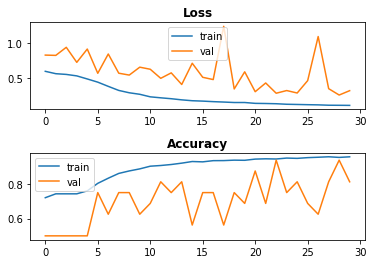



Confusion Matrix, without normalization


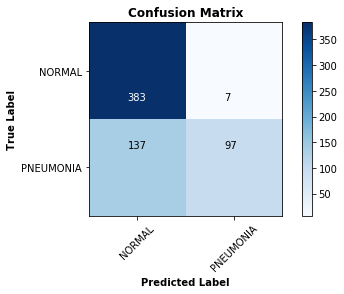



              precision    recall  f1-score   support

      NORMAL       0.74      0.98      0.84       390
   PNEUMONIA       0.93      0.41      0.57       234

    accuracy                           0.77       624
   macro avg       0.83      0.70      0.71       624
weighted avg       0.81      0.77      0.74       624



In [108]:
print(evaluate_test(model_transform_shear, history_transform_shear, class_labels_base, train_images_shear, test_images_shear, train_y_shear, test_y_shear))

### Zoom 90%, applied to Train only

In [93]:
train_generator_zoom_train = ImageDataGenerator(rescale=1./255,
                                           zoom_range=[.9, .9]).flow_from_directory(train_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 5218)
test_generator_zoom_train = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 624)
val_generator_zoom_train = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 18)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [101]:
class_labels_zoom_train = list(train_generator_zoom_train.class_indices.keys())
train_images_zoom_train, train_labels_zoom_train = next(train_generator_zoom_train)
test_images_zoom_train, test_labels_zoom_train = next(test_generator_zoom_train)
val_images_zoom_train, val_labels_zoom_train = next(val_generator_zoom_train)
train_y_zoom_train = np.reshape(train_labels_zoom_train[:,0], (5216,1))
test_y_zoom_train = np.reshape(test_labels_zoom_train[:,0], (624,1))
val_y_zoom_train = np.reshape(val_labels_zoom_train[:,0], (16,1))
print ("train_images shape: " + str(train_images_zoom_train.shape))
print ("train_labels shape: " + str(train_labels_zoom_train.shape))
print ("test_images shape: " + str(test_images_zoom_train.shape))
print ("test_labels shape: " + str(test_labels_zoom_train.shape))
print ("val_images shape: " + str(val_images_zoom_train.shape))
print ("val_labels shape: " + str(val_labels_zoom_train.shape))

train_images shape: (5216, 64, 64, 1)
train_labels shape: (5216, 2)
test_images shape: (624, 64, 64, 1)
test_labels shape: (624, 2)
val_images shape: (16, 64, 64, 1)
val_labels shape: (16, 2)


In [102]:
model_transform_zoom_train = models.Sequential()
model_transform_zoom_train.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_transform_zoom_train.add(layers.MaxPooling2D((2, 2)))

model_transform_zoom_train.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_transform_zoom_train.add(layers.MaxPooling2D((2, 2)))

model_transform_zoom_train.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_transform_zoom_train.add(layers.MaxPooling2D((2, 2)))

model_transform_zoom_train.add(layers.Flatten())
model_transform_zoom_train.add(layers.Dense(64, activation='relu'))
model_transform_zoom_train.add(layers.Dense(1, activation='sigmoid'))

model_transform_zoom_train.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [103]:
%%time
history_transform_zoom_train = model_transform_zoom_train.fit(train_images_zoom_train,
                    train_y_zoom_train,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_zoom_train, val_y_zoom_train))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 1s 244us/step - loss: 0.5866 - acc: 0.7429 - val_loss: 0.8275 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 1s 215us/step - loss: 0.5695 - acc: 0.7429 - val_loss: 0.8439 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 1s 213us/step - loss: 0.5631 - acc: 0.7429 - val_loss: 0.8419 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 1s 215us/step - loss: 0.5513 - acc: 0.7429 - val_loss: 0.7811 - val_acc: 0.5000
Epoch 5/30
5216/5216 [==============================] - 1s 229us/step - loss: 0.5273 - acc: 0.7429 - val_loss: 0.8489 - val_acc: 0.5000
Epoch 6/30
5216/5216 [==============================] - 1s 214us/step - loss: 0.4727 - acc: 0.7644 - val_loss: 1.1892 - val_acc: 0.5000
Epoch 7/30
5216/5216 [==============================] - 1s 207us/step - loss: 0.4287 - acc: 0.8060 - val_loss: 0.5738 - val_acc: 0.7500
Ep

Accuracy 
 Train: 0.927, Test: 0.809
Loss 
 Train: 0.198, Test: 0.522 



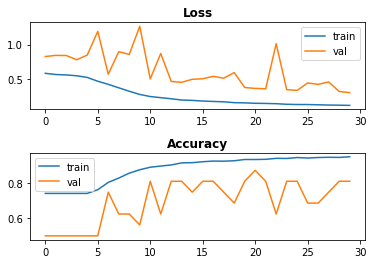



Confusion Matrix, without normalization


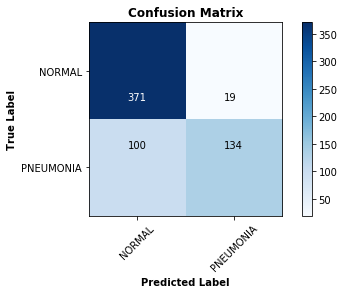



              precision    recall  f1-score   support

      NORMAL       0.79      0.95      0.86       390
   PNEUMONIA       0.88      0.57      0.69       234

    accuracy                           0.81       624
   macro avg       0.83      0.76      0.78       624
weighted avg       0.82      0.81      0.80       624



In [109]:
print(evaluate_test(model_transform_zoom_train, history_transform_zoom_train, class_labels_base, train_images_zoom_train, test_images_zoom_train, train_y_zoom_train, test_y_zoom_train))

### Zoom 90%, applied to Train, Val, and Test

In [97]:
train_generator_zoom_all = ImageDataGenerator(rescale=1./255,
                                                zoom_range=[.9, .9]).flow_from_directory(train_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 5218)
test_generator_zoom_all = ImageDataGenerator(rescale=1./255,
                                               zoom_range=[.9, .9]).flow_from_directory(test_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 624)
val_generator_zoom_all = ImageDataGenerator(rescale=1./255,
                                              zoom_range=[.9, .9]).flow_from_directory(val_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 18)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [106]:
class_labels_zoom_all = list(train_generator_zoom_all.class_indices.keys())
train_images_zoom_all, train_labels_zoom_all = next(train_generator_zoom_all)
test_images_zoom_all, test_labels_zoom_all = next(test_generator_zoom_all)
val_images_zoom_all, val_labels_zoom_all = next(val_generator_zoom_all)
train_y_zoom_all = np.reshape(train_labels_zoom_all[:,0], (5216,1))
test_y_zoom_all = np.reshape(test_labels_zoom_all[:,0], (624,1))
val_y_zoom_all = np.reshape(val_labels_zoom_all[:,0], (16,1))
print ("train_images shape: " + str(train_images_zoom_all.shape))
print ("train_labels shape: " + str(train_labels_zoom_all.shape))
print ("test_images shape: " + str(test_images_zoom_all.shape))
print ("test_labels shape: " + str(test_labels_zoom_all.shape))
print ("val_images shape: " + str(val_images_zoom_all.shape))
print ("val_labels shape: " + str(val_labels_zoom_all.shape))

train_images shape: (5216, 64, 64, 1)
train_labels shape: (5216, 2)
test_images shape: (624, 64, 64, 1)
test_labels shape: (624, 2)
val_images shape: (16, 64, 64, 1)
val_labels shape: (16, 2)


In [112]:
model_transform_zoom_all = models.Sequential()
model_transform_zoom_all.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_transform_zoom_all.add(layers.MaxPooling2D((2, 2)))

model_transform_zoom_all.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_transform_zoom_all.add(layers.MaxPooling2D((2, 2)))

model_transform_zoom_all.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_transform_zoom_all.add(layers.MaxPooling2D((2, 2)))

model_transform_zoom_all.add(layers.Flatten())
model_transform_zoom_all.add(layers.Dense(64, activation='relu'))
model_transform_zoom_all.add(layers.Dense(1, activation='sigmoid'))

model_transform_zoom_all.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [113]:
%%time
history_transform_zoom_all = model_transform_zoom_all.fit(train_images_zoom_all,
                    train_y_zoom_all,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_zoom_all, val_y_zoom_all))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 1s 244us/step - loss: 0.5850 - acc: 0.7429 - val_loss: 0.8180 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 1s 216us/step - loss: 0.5631 - acc: 0.7429 - val_loss: 0.8330 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 1s 213us/step - loss: 0.5529 - acc: 0.7429 - val_loss: 0.8355 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 1s 211us/step - loss: 0.5316 - acc: 0.7429 - val_loss: 0.8476 - val_acc: 0.5000
Epoch 5/30
5216/5216 [==============================] - 1s 213us/step - loss: 0.4715 - acc: 0.7623 - val_loss: 0.8616 - val_acc: 0.5625
Epoch 6/30
5216/5216 [==============================] - 1s 225us/step - loss: 0.4118 - acc: 0.8200 - val_loss: 0.6024 - val_acc: 0.6250
Epoch 7/30
5216/5216 [==============================] - 1s 223us/step - loss: 0.3816 - acc: 0.8378 - val_loss: 0.5141 - val_acc: 0.8125
Ep

Accuracy 
 Train: 0.937, Test: 0.678
Loss 
 Train: 0.160, Test: 1.207 



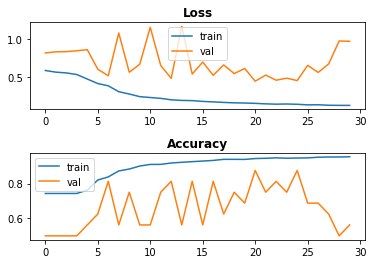



Confusion Matrix, without normalization


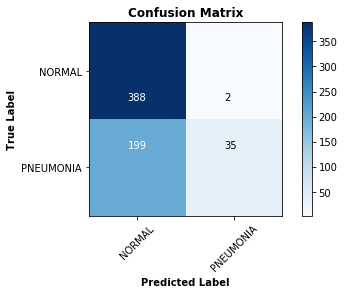



              precision    recall  f1-score   support

      NORMAL       0.66      0.99      0.79       390
   PNEUMONIA       0.95      0.15      0.26       234

    accuracy                           0.68       624
   macro avg       0.80      0.57      0.53       624
weighted avg       0.77      0.68      0.59       624



In [114]:
print(evaluate_test(model_transform_zoom_all, history_transform_zoom_all, class_labels_base, train_images_zoom_all, test_images_zoom_all, train_y_zoom_all, test_y_zoom_all))

### Shift, Shear, and Zoom

In [115]:
train_generator_transforms = ImageDataGenerator(rescale=1./255,
                                                width_shift_range=0.1,
                                                height_shift_range=0.1,
                                                shear_range=15,
                                                zoom_range=[.9, .9]).flow_from_directory(train_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 5218)
test_generator_transforms = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 624)
val_generator_transforms = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(64, 64), color_mode = 'grayscale', batch_size = 18)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [116]:
class_labels_transforms = list(train_generator_transforms.class_indices.keys())
train_images_transforms, train_labels_transforms = next(train_generator_transforms)
test_images_transforms, test_labels_transforms = next(test_generator_transforms)
val_images_transforms, val_labels_transforms = next(val_generator_transforms)
train_y_transforms = np.reshape(train_labels_transforms[:,0], (5216,1))
test_y_transforms = np.reshape(test_labels_transforms[:,0], (624,1))
val_y_transforms = np.reshape(val_labels_transforms[:,0], (16,1))
print ("train_images shape: " + str(train_images_transforms.shape))
print ("train_labels shape: " + str(train_labels_transforms.shape))
print ("test_images shape: " + str(test_images_transforms.shape))
print ("test_labels shape: " + str(test_labels_transforms.shape))
print ("val_images shape: " + str(val_images_transforms.shape))
print ("val_labels shape: " + str(val_labels_transforms.shape))

train_images shape: (5216, 64, 64, 1)
train_labels shape: (5216, 2)
test_images shape: (624, 64, 64, 1)
test_labels shape: (624, 2)
val_images shape: (16, 64, 64, 1)
val_labels shape: (16, 2)


In [117]:
model_transform_combined = models.Sequential()
model_transform_combined.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
model_transform_combined.add(layers.MaxPooling2D((2, 2)))

model_transform_combined.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_transform_combined.add(layers.MaxPooling2D((2, 2)))

model_transform_combined.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_transform_combined.add(layers.MaxPooling2D((2, 2)))

model_transform_combined.add(layers.Flatten())
model_transform_combined.add(layers.Dense(64, activation='relu'))
model_transform_combined.add(layers.Dense(1, activation='sigmoid'))

model_transform_combined.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [118]:
%%time
history_transform_combined = model_transform_combined.fit(train_images_transforms,
                    train_y_transforms,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_transforms, val_y_transforms))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 1s 234us/step - loss: 0.5925 - acc: 0.7421 - val_loss: 0.8589 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 1s 222us/step - loss: 0.5676 - acc: 0.7429 - val_loss: 0.8579 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 1s 228us/step - loss: 0.5635 - acc: 0.7429 - val_loss: 0.8139 - val_acc: 0.5000
Epoch 4/30
5216/5216 [==============================] - 1s 212us/step - loss: 0.5577 - acc: 0.7429 - val_loss: 0.8057 - val_acc: 0.5000
Epoch 5/30
5216/5216 [==============================] - 1s 222us/step - loss: 0.5458 - acc: 0.7429 - val_loss: 0.6946 - val_acc: 0.5000
Epoch 6/30
5216/5216 [==============================] - 1s 225us/step - loss: 0.5265 - acc: 0.7452 - val_loss: 0.6581 - val_acc: 0.6250
Epoch 7/30
5216/5216 [==============================] - 1s 212us/step - loss: 0.4990 - acc: 0.7602 - val_loss: 0.7520 - val_acc: 0.5625
Ep

Accuracy 
 Train: 0.880, Test: 0.776
Loss 
 Train: 0.296, Test: 0.696 



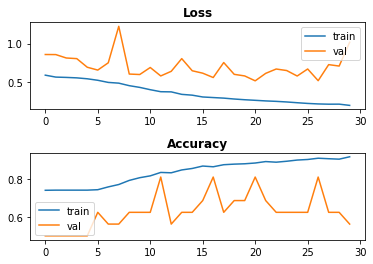



Confusion Matrix, without normalization


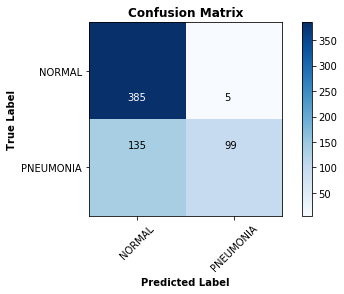



              precision    recall  f1-score   support

      NORMAL       0.74      0.99      0.85       390
   PNEUMONIA       0.95      0.42      0.59       234

    accuracy                           0.78       624
   macro avg       0.85      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624



In [119]:
print(evaluate_test(model_transform_combined, history_transform_combined, class_labels_base, train_images_transforms, test_images_transforms, train_y_transforms, test_y_transforms))

## Downsample size (baseline: 64x64)

### 128x128

In [120]:
train_generator_128 = ImageDataGenerator(rescale=1./255).flow_from_directory(train_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 5218)
test_generator_128 = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 624)
val_generator_128 = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(128, 128), color_mode = 'grayscale', batch_size = 18)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [121]:
class_labels_128 = list(train_generator_128.class_indices.keys())
train_images_128, train_labels_128 = next(train_generator_128)
test_images_128, test_labels_128 = next(test_generator_128)
val_images_128, val_labels_128 = next(val_generator_128)
train_y_128 = np.reshape(train_labels_128[:,0], (5216,1))
test_y_128 = np.reshape(test_labels_128[:,0], (624,1))
val_y_128 = np.reshape(val_labels_128[:,0], (16,1))
print ("train_images shape: " + str(train_images_128.shape))
print ("train_labels shape: " + str(train_labels_128.shape))
print ("test_images shape: " + str(test_images_128.shape))
print ("test_labels shape: " + str(test_labels_128.shape))
print ("val_images shape: " + str(val_images_128.shape))
print ("val_labels shape: " + str(val_labels_128.shape))

train_images shape: (5216, 128, 128, 1)
train_labels shape: (5216, 2)
test_images shape: (624, 128, 128, 1)
test_labels shape: (624, 2)
val_images shape: (16, 128, 128, 1)
val_labels shape: (16, 2)


In [122]:
model_downsample_128 = models.Sequential()
model_downsample_128.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model_downsample_128.add(layers.MaxPooling2D((2, 2)))

model_downsample_128.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_downsample_128.add(layers.MaxPooling2D((2, 2)))

model_downsample_128.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_downsample_128.add(layers.MaxPooling2D((2, 2)))

model_downsample_128.add(layers.Flatten())
model_downsample_128.add(layers.Dense(64, activation='relu'))
model_downsample_128.add(layers.Dense(1, activation='sigmoid'))

model_downsample_128.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [123]:
%%time
history_downsample_128 = model_downsample_128.fit(train_images_128,
                    train_y_128,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_128, val_y_128))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 5s 865us/step - loss: 0.5695 - acc: 0.7429 - val_loss: 0.8593 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 4s 755us/step - loss: 0.5000 - acc: 0.7634 - val_loss: 0.6481 - val_acc: 0.6250
Epoch 3/30
5216/5216 [==============================] - 4s 758us/step - loss: 0.4214 - acc: 0.8144 - val_loss: 0.5433 - val_acc: 0.6250
Epoch 4/30
5216/5216 [==============================] - 4s 746us/step - loss: 0.3328 - acc: 0.8681 - val_loss: 0.8107 - val_acc: 0.6250
Epoch 5/30
5216/5216 [==============================] - 4s 755us/step - loss: 0.2666 - acc: 0.8859 - val_loss: 0.6060 - val_acc: 0.7500
Epoch 6/30
5216/5216 [==============================] - 4s 739us/step - loss: 0.2231 - acc: 0.9093 - val_loss: 0.7137 - val_acc: 0.6875
Epoch 7/30
5216/5216 [==============================] - 4s 742us/step - loss: 0.1940 - acc: 0.9258 - val_loss: 0.6606 - val_acc: 0.6250
Ep

Accuracy 
 Train: 0.964, Test: 0.731
Loss 
 Train: 0.097, Test: 1.067 



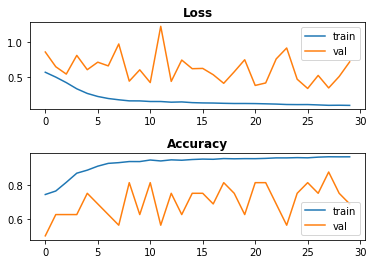



Confusion Matrix, without normalization


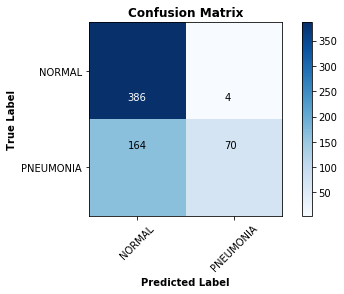



              precision    recall  f1-score   support

      NORMAL       0.70      0.99      0.82       390
   PNEUMONIA       0.95      0.30      0.45       234

    accuracy                           0.73       624
   macro avg       0.82      0.64      0.64       624
weighted avg       0.79      0.73      0.68       624



In [124]:
print(evaluate_test(model_downsample_128, history_downsample_128, class_labels_base, train_images_128, test_images_128, train_y_128, test_y_128))

### 256x256

In [125]:
train_generator_256 = ImageDataGenerator(rescale=1./255).flow_from_directory(train_folder, target_size=(256, 256), color_mode = 'grayscale', batch_size = 5218)
test_generator_256 = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder, target_size=(256, 256), color_mode = 'grayscale', batch_size = 624)
val_generator_256 = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder, target_size=(256, 256), color_mode = 'grayscale', batch_size = 18)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [126]:
class_labels_256 = list(train_generator_256.class_indices.keys())
train_images_256, train_labels_256 = next(train_generator_256)
test_images_256, test_labels_256 = next(test_generator_256)
val_images_256, val_labels_256 = next(val_generator_256)
train_y_256 = np.reshape(train_labels_256[:,0], (5216,1))
test_y_256 = np.reshape(test_labels_256[:,0], (624,1))
val_y_256 = np.reshape(val_labels_256[:,0], (16,1))
print ("train_images shape: " + str(train_images_256.shape))
print ("train_labels shape: " + str(train_labels_256.shape))
print ("test_images shape: " + str(test_images_256.shape))
print ("test_labels shape: " + str(test_labels_256.shape))
print ("val_images shape: " + str(val_images_256.shape))
print ("val_labels shape: " + str(val_labels_256.shape))

train_images shape: (5216, 256, 256, 1)
train_labels shape: (5216, 2)
test_images shape: (624, 256, 256, 1)
test_labels shape: (624, 2)
val_images shape: (16, 256, 256, 1)
val_labels shape: (16, 2)


In [127]:
model_downsample_256 = models.Sequential()
model_downsample_256.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
model_downsample_256.add(layers.MaxPooling2D((2, 2)))

model_downsample_256.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_downsample_256.add(layers.MaxPooling2D((2, 2)))

model_downsample_256.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_downsample_256.add(layers.MaxPooling2D((2, 2)))

model_downsample_256.add(layers.Flatten())
model_downsample_256.add(layers.Dense(64, activation='relu'))
model_downsample_256.add(layers.Dense(1, activation='sigmoid'))

model_downsample_256.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [128]:
%%time
history_downsample_256 = model_downsample_256.fit(train_images_256,
                    train_y_256,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images_256, val_y_256))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 15s 3ms/step - loss: 0.5457 - acc: 0.7475 - val_loss: 0.6069 - val_acc: 0.6250
Epoch 2/30
5216/5216 [==============================] - 14s 3ms/step - loss: 0.4185 - acc: 0.8206 - val_loss: 1.0573 - val_acc: 0.6250
Epoch 3/30
5216/5216 [==============================] - 14s 3ms/step - loss: 0.2694 - acc: 0.8934 - val_loss: 0.6914 - val_acc: 0.6250
Epoch 4/30
5216/5216 [==============================] - 14s 3ms/step - loss: 0.2076 - acc: 0.9176 - val_loss: 0.5647 - val_acc: 0.7500
Epoch 5/30
5216/5216 [==============================] - 14s 3ms/step - loss: 0.1746 - acc: 0.9321 - val_loss: 0.3949 - val_acc: 0.8125
Epoch 6/30
5216/5216 [==============================] - 14s 3ms/step - loss: 0.1521 - acc: 0.9406 - val_loss: 0.4958 - val_acc: 0.7500
Epoch 7/30
5216/5216 [==============================] - 15s 3ms/step - loss: 0.1439 - acc: 0.9465 - val_loss: 0.5387 - val_acc: 0.6875
Epoch 8/3

Accuracy 
 Train: 0.978, Test: 0.777
Loss 
 Train: 0.061, Test: 0.930 



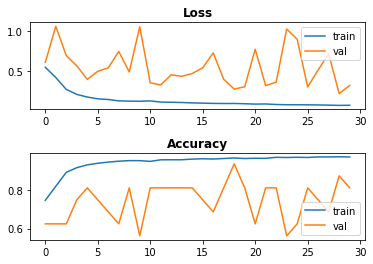



Confusion Matrix, without normalization


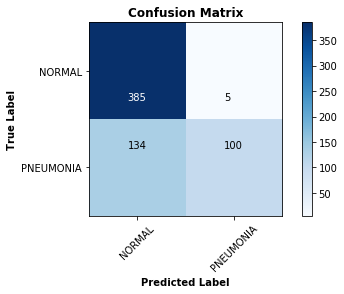



              precision    recall  f1-score   support

      NORMAL       0.74      0.99      0.85       390
   PNEUMONIA       0.95      0.43      0.59       234

    accuracy                           0.78       624
   macro avg       0.85      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624



In [129]:
print(evaluate_test(model_downsample_256, history_downsample_256, class_labels_base, train_images_256, test_images_256, train_y_256, test_y_256))

# Metrics Functions

In [21]:
def evaluate_test(model, history, class_labels, train_X, test_X, train_y, test_y):
    """Return evaluation metrics for given model on given train and test sets."""
    train_loss, train_acc = model.evaluate(train_X, train_y, verbose=0)
    test_loss, test_acc = model.evaluate(test_X, test_y, verbose=0)
    print('Accuracy \n Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    print('Loss \n Train: %.3f, Test: %.3f \n' % (train_loss, test_loss))
    # plot loss during training
    plt.subplots_adjust(hspace = .5, wspace = 0.5)
    plt.subplot(211)
    plt.title('Loss', weight='bold')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy', weight='bold')
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='val')
    plt.legend()
    plt.show()
    print('\n')
    # predict probabilities for test set
    yhat_probs = model.predict(test_X, verbose=0)
    # predict crisp classes for test set
    yhat_classes = model.predict_classes(test_X, verbose=0)
    # reduce to 1d array
    yhat_probs = yhat_probs[:, 0]
    yhat_classes = yhat_classes[:, 0]
    # calculate metrics
    report = metrics.classification_report(test_y, yhat_classes, target_names=class_labels)
    confusion_matrix = metrics.confusion_matrix(test_y, yhat_classes)
    plot_confusion_matrix(confusion_matrix, class_labels, cmap=plt.cm.Blues)
    print('\n')
    
    return report

In [10]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if i == 0:
            plt.text(j-0.1, i+0.3, format(cm[i, j], fmt), color="white" if cm[i, j] > thresh else "black")
        if i == 1:
            plt.text(j-0.1, i-0.2, format(cm[i, j], fmt), color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label', weight='bold')
    plt.xlabel('Predicted Label', weight='bold')
    plt.show()
